In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from nzdownscale.downscaler.validate_v2 import ValidateV2
from datetime import datetime, timedelta

In [3]:
model_name = 'hourly_v2'
var = 'temperature'

model_dir = f'/home/emily/deepsensor/deepweather-downscaling/experiments/'\
            f'models/{var}/{model_name}'
model_path = f'{model_dir}/{model_name}.pt'
train_metadata_path = f'{model_dir}/metadata_{model_name}.pkl'
data_processor_path = f'{model_dir}/data_processor.pkl'
task_loader_path = f'{model_dir}/task_loader.pkl'

In [4]:
validate = ValidateV2(model_path,
                      data_processor_path,
                      task_loader_path,
                      train_metadata_path)

In [5]:
time = [datetime(2010, 1, 1, i) for i in range(24)]

In [6]:
pred = validate.predict(time)

Loading ERA5:   0%|          | 0/6 [00:00<?, ?it/s]

Loading stations: 100%|██████████| 444/444 [01:28<00:00,  5.04it/s]


159 stations with data at ['2010-01-01T00:00:00.000000000' '2010-01-01T01:00:00.000000000'
 '2010-01-01T02:00:00.000000000' '2010-01-01T03:00:00.000000000'
 '2010-01-01T04:00:00.000000000' '2010-01-01T05:00:00.000000000'
 '2010-01-01T06:00:00.000000000' '2010-01-01T07:00:00.000000000'
 '2010-01-01T08:00:00.000000000' '2010-01-01T09:00:00.000000000'
 '2010-01-01T10:00:00.000000000' '2010-01-01T11:00:00.000000000'
 '2010-01-01T12:00:00.000000000' '2010-01-01T13:00:00.000000000'
 '2010-01-01T14:00:00.000000000' '2010-01-01T15:00:00.000000000'
 '2010-01-01T16:00:00.000000000' '2010-01-01T17:00:00.000000000'
 '2010-01-01T18:00:00.000000000' '2010-01-01T19:00:00.000000000'
 '2010-01-01T20:00:00.000000000' '2010-01-01T21:00:00.000000000'
 '2010-01-01T22:00:00.000000000' '2010-01-01T23:00:00.000000000']
Pre-processing ERA5 data
Pre-processing station data
dim_yc inferred from TaskLoader: (8, 6, 1, 1)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 5
Setting aux_t_mlp_lay

 33%|███▎      | 8/24 [15:54<34:22, 128.92s/it]

(array([2.96400000e+03, 2.63546000e+05, 3.56094300e+06, 1.98444020e+07,
        8.19463141e+08, 2.62747461e+08, 5.03996770e+07, 1.60007750e+07,
        3.72696900e+06, 3.26146000e+05]),
 array([-4.48679256, -0.50191987,  3.48295283,  7.46782541, 11.45269871,
        15.43757057, 19.42244339, 23.40731621, 27.39218903, 31.37706184,
        35.36193466]),
 <BarContainer object of 10 artists>)

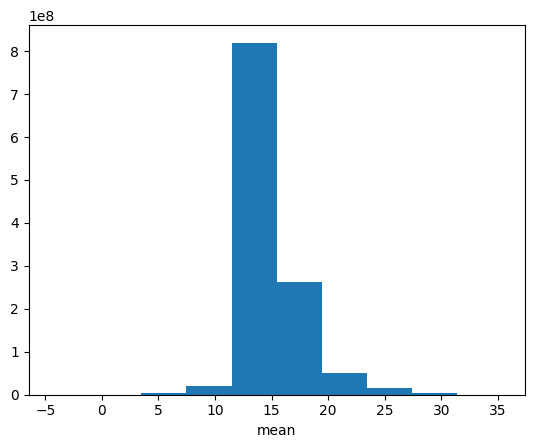

In [ ]:
pred['dry_bulb']['mean'].to_netcdf(f'{model_dir}/pred_20100101.nc')